In [11]:
# Uncomment the following line to install gurobipy if you haven't installed it
# !pip install gurobipy

import cvxpy as cp
import numpy as np
import sys

import seaborn as sns
import matplotlib.pyplot as plt

class Benders:
    # ... (existing code)
    
    def __init__(self):
        # Data (replace with your data)
        self.Nx = 2
        self.Ny = 1
        self.m = 2
        self.n = 1
        self.c = np.array([-4, -3]).reshape((self.Nx, 1))
        self.f = np.array([-5]).reshape((self.Ny, 1))
        self.A = np.array([[-2, -3], [-2, -1]]).reshape((self.m, self.Nx))
        self.B = np.array([-1, -3]).reshape((self.m, self.Ny))
        self.b = np.array([-12, -12]).reshape((self.m, 1))
        self.D = np.array([-1]).reshape((self.n, self.Ny))
        self.d = np.array([-20]).reshape((self.n, 1))

        self.y_init = np.array([4], dtype=int).reshape((self.Ny, 1))  # Initial feasible guess (Important!)

        self.eps = 1e-3
        self.max_iterations = 20
        self.LB = sys.float_info.min
        self.UB = sys.float_info.max
        self.optimality_cuts = []
        self.feasibility_cuts = []
        self.lower_bounds = []
        self.upper_bounds = []

    def solve_subproblem(self, y):
        p = cp.Variable((self.m, 1))
        objective = p.T @ (self.b - self.B @ y)
        constraints = [p.T @ self.A <= self.c.T, p >= np.zeros((self.m, 1))]
        prob = cp.Problem(cp.Maximize(objective), constraints)
        
        # Use Gurobi solver instead of MOSEK
        prob.solve(solver=cp.GUROBI, verbose=False)
        
        x_sol = constraints[0].dual_value

        return p.value, prob.value, prob.status, x_sol

    def solve_modified_subproblem(self, y):
        p = cp.Variable((self.m, 1))
        constraints = [p.T @ (self.b - self.B @ y) == 1, p.T @ self.A <= np.zeros((1, self.Nx)), p >= np.zeros((self.m, 1))]
        prob = cp.Problem(cp.Maximize(0), constraints)
        
        # Use Gurobi solver instead of MOSEK
        prob.solve(solver=cp.GUROBI, verbose=False)
        
        return p.value

    def solve_master_problem(self):
        y = cp.Variable((self.Ny, 1), integer=True)
        n = cp.Variable(1)
        objective = self.f.T @ y + n
        constraints = [self.D @ y >= self.d, y >= np.zeros((self.Ny, 1))]
        
        for p in self.optimality_cuts:
            constraints.append(n >= p.T @ (self.b - self.B @ y))  # Add optimality cuts
        for r in self.feasibility_cuts:
            constraints.append(0 >= r.T @ (self.b - self.B @ y))  # Add feasibility cuts
        
        # Use Gurobi solver instead of MOSEK
        prob = cp.Problem(cp.Minimize(objective), constraints)
        prob.solve(solver=cp.GUROBI, verbose=False)

        return y.value, prob.value
    
    def show_results(self, i, obj_value_master, x_sol, y_sol):
        """Displays the results of the optimization problem.

        Inputs:
          - i(int):                  The index of the last iteration
          - obj_value_master(float): The objective function value of the master problem
          - x_sol(np.ndarray):       The optimal x solution [Nx,1]
          - y_sol(np.ndarray):       The optimal y solution [Ny,1]
        """

        if i > self.max_iterations:
            print("\nThe algorithm did not converge in the given iterations.")
        else:
            print("\n*** Optimal solution to the MILP problem found. ***")
        print("The optimal value is: {}".format(obj_value_master))

        if x_sol is not None:
            print("The optimal solution is x*={}, y*={}".format(*x_sol, *y_sol))
        else:
            print("\nThe algorithm did not find the optimal solution. Please try another initial feasible guess y_init!")

    def solve_problem(self):
        """Solves the MILP using Benders decomposition."""
        i = 0
        y_sol = self.y_init

        while abs((self.UB - self.LB)/self.UB) >= self.eps and i <= self.max_iterations:

            # Solve sub-problem
            p, obj_value_sp, sp_status, _ = self.solve_subproblem(y_sol)

            # Add optimality or feasibility cut for Master problem
            if sp_status == 'optimal':  # Sub-problem feasible
                # Add optimality cut
                self.optimality_cuts.append(p)

                # Update upper bound
                self.UB = min(self.UB, np.dot(np.transpose(self.f), y_sol).item() + obj_value_sp)

            else:                       # Sub-problem unbounded
                # Solve Modified Sub-problem
                r = self.solve_modified_subproblem(y_sol)

                # Add feasibility cut
                self.feasibility_cuts.append(r)

            # Solve Master problem
            y_sol, obj_value_master = self.solve_master_problem()

            # Update lower bound
            self.LB = obj_value_master

            # Update iteration index
            i = i + 1

            # Save values for plotting
            self.lower_bounds.append(self.LB)
            self.upper_bounds.append(self.UB)

            print("Iteration i={} : UB={}, LB={}".format(i, self.UB, self.LB))

        # Solve sub-problem with the optimal y solution to get the optimal x solution
        _, _, _, x_sol = self.solve_subproblem(y_sol)

        # Display the results
        self.show_results(i, obj_value_master, x_sol, y_sol)

In [12]:
def plot_convergence(upper_bounds, lower_bounds):
    """Plots the convergence of the algorithm (upper & lower bounds vs iteration)."""

    sns.set_theme()
    fig, ax = plt.subplots()
    ax.set_title("Benders Decomposition Convergence")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective function bounds')
    iters = np.arange(1, len(upper_bounds)+1, 1, dtype=int)
    plt.plot(iters, upper_bounds, 'o-', label='Upper bound')
    plt.plot(iters, lower_bounds, 'o-', label='Lower bound')
    plt.xticks(iters)
    plt.legend()
    plt.show()
    plt.savefig('images/convergence.png')


Iteration i=1 : UB=-20.0, LB=-36.0
Iteration i=2 : UB=-24.0, LB=-28.0
Iteration i=3 : UB=-24.0, LB=-24.0

*** Optimal solution to the MILP problem found. ***
The optimal value is: -24.0
The optimal solution is x*=[ 6. -0.], y*=[0.]


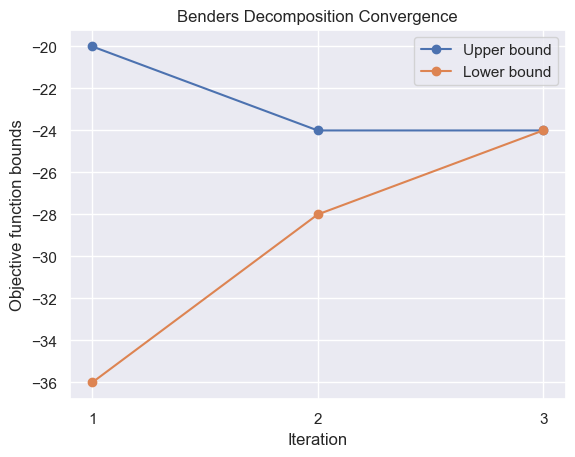

FileNotFoundError: [Errno 2] No such file or directory: 'images/convergence.png'

<Figure size 640x480 with 0 Axes>

In [13]:
def main():
    """Solves the (MILP) optimization problem."""
    #benders_dec = Benders()
    #benders_dec.solve_problem()
    # Create an instance of the Benders class
    benders_solver = Benders()

    # Solve the MILP using Benders decomposition with Gurobi solver
    benders_solver.solve_problem()
    plot_convergence(benders_solver.upper_bounds, benders_solver.lower_bounds)


if __name__ == '__main__':
    main()

In [ ]:
pip install MOSEK

In [ ]:
pip install gurobipy